In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [7]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [8]:
# min-max normalization
predict = predict.apply(lambda x: np.log(1 + np.exp(x)), axis=1)
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [9]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.215425,0.000154,0.000000,0.000033,0.312113,0.472275,0.472275,5,Walking,Walking
1,0.001045,0.000000,0.658861,0.317042,0.020874,0.002178,0.658861,2,Sitting,Sitting
2,0.270764,0.000000,0.000003,0.000235,0.485462,0.243537,0.485462,4,Upstairs,Upstairs
3,0.216629,0.768216,0.000321,0.014457,0.000378,0.000000,0.768216,1,Jogging,Jogging
4,0.006257,0.006284,0.052117,0.923579,0.000000,0.011762,0.923579,3,Standing,Standing
5,0.006493,0.000017,0.000000,0.000176,0.090018,0.903296,0.903296,5,Walking,Walking
6,0.774410,0.000033,0.000000,0.000293,0.221663,0.003602,0.774410,0,Downstairs,Downstairs
7,0.639722,0.000000,0.000295,0.000440,0.132734,0.226810,0.639722,0,Downstairs,Downstairs
8,0.007823,0.955566,0.027313,0.001881,0.000000,0.007416,0.955566,1,Jogging,Jogging
9,0.092593,0.000042,0.000000,0.000343,0.014111,0.892912,0.892912,5,Walking,Walking


Accuracy:  0.9520456476872647


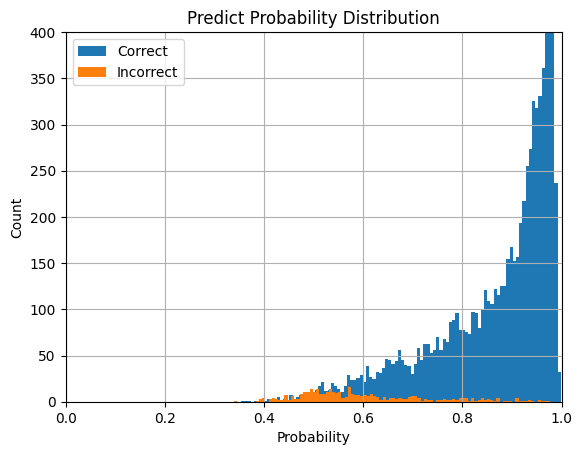

In [10]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [11]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.852344
std       0.134662
min       0.338791
max       0.998108
median    0.903166
Name: predict_probability, dtype: float64

In [22]:
thresholds = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        # 'confidence_count': len(df_confidence),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS[:len(cm)], columns=LABELS[:len(cm)])
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,confidence_count,drop_accuracy,drop_ratio
threshold,,,,,
0.0,0.952046,1.000000,8237,0.000000,0.000000
0.4,0.953047,0.998058,8221,0.437500,0.001942
0.5,0.961967,0.979968,8072,0.466667,0.020032
0.6,0.978913,0.926915,7635,0.611296,0.073085
0.7,0.986963,0.847396,6980,0.758154,0.152604
0.8,0.991727,0.719072,5923,0.850475,0.280928
0.9,0.996433,0.510501,4205,0.905754,0.489499


# process to gaussian

Before standardization
std: 0.13466243423990396
--- After standardization ---
std: 1.0


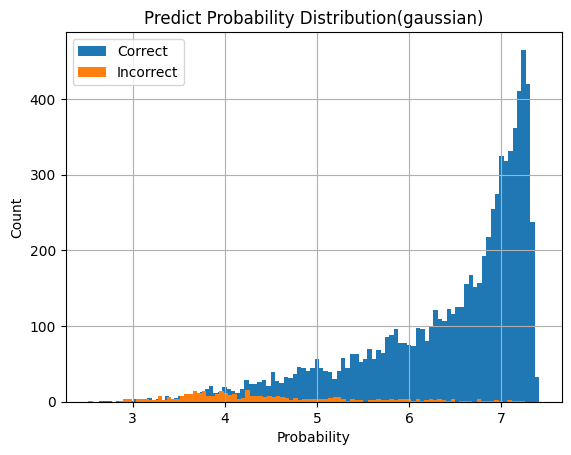

In [13]:
print("Before standardization")
std = df["predict_probability"].std()
print(f"std: {std}")
df["predict_probability_gaussian"] = df["predict_probability"].apply(lambda x: x / std)
print("--- After standardization ---")
std = df["predict_probability_gaussian"].std()
print(f"std: {std}")
df.loc[df.true_label==df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
plt.title('Predict Probability Distribution(gaussian)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [14]:
thresholds = [0, 6, 8,  9, 10]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_gaussian'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0,0.952046,1.000000,0.000000,0.000000
6,0.992444,0.706932,0.854598,0.293068
8,0.000000,0.000000,0.952046,1.000000
9,0.000000,0.000000,0.952046,1.000000
10,0.000000,0.000000,0.952046,1.000000


# process to torncurve

## 1 - (1 - x) ** 2

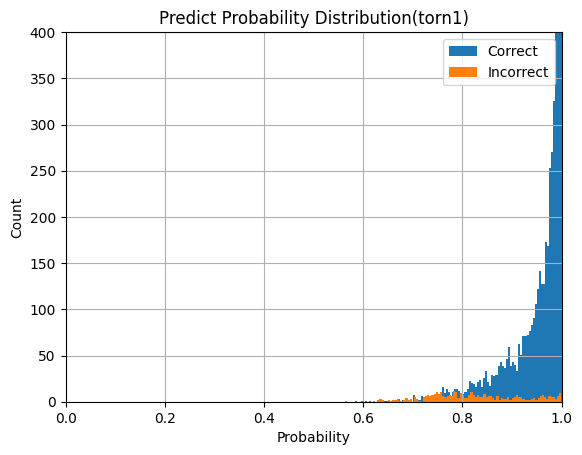

In [15]:
torn1_function = lambda x: 1-(1-x)**2
df["predict_probability_torn1"] = df["predict_probability"].apply(torn1_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn1'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn1'].hist(bins=100)
plt.title('Predict Probability Distribution(torn1)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [16]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn1'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952046,1.000000,0.000000,0.000000
0.5,0.952046,1.000000,0.000000,0.000000
0.6,0.952150,0.999636,0.666667,0.000364
0.7,0.955623,0.993080,0.438596,0.006920
0.8,0.972130,0.953988,0.535620,0.046012


## 1/ln(2) * ln(1+x)

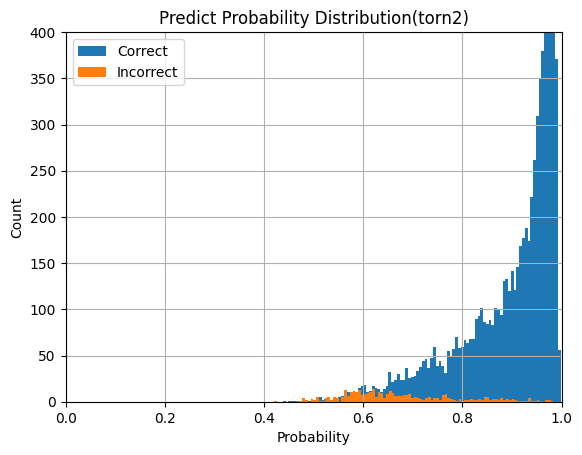

In [17]:
torn2_function = lambda x: (1/np.log(2))*np.log(1+x)
df["predict_probability_torn2"] = df["predict_probability"].apply(torn2_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn2'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn2'].hist(bins=100)
plt.title('Predict Probability Distribution(torn2)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [18]:
thresholds = [0, 0.5, 0.55, 0.6, 0.65]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn2'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9682/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.952046,1.000000,0.000000,0.000000
0.50,0.953372,0.997208,0.478261,0.002792
0.55,0.956623,0.990773,0.460526,0.009227
0.60,0.965160,0.972199,0.493450,0.027801
0.65,0.974244,0.947432,0.551963,0.052568


/home/nakagawa/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1009: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


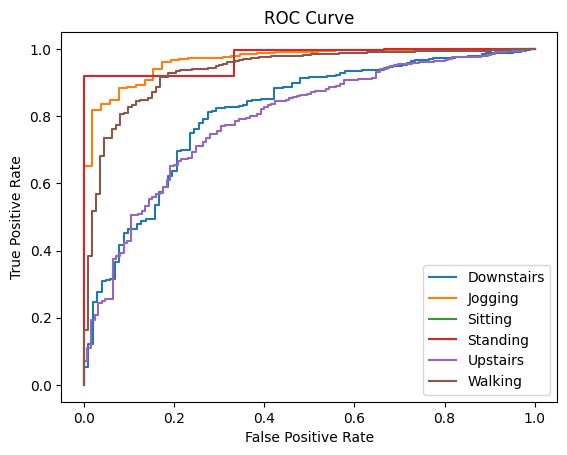

In [19]:
from sklearn.metrics import roc_curve

LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()